In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
from osc_discovery.acquisition_function import linear_correct_to_b3lyp

import seaborn as sns
sns.set()
sns.set(font_scale=2)
sns.set_context("talk")

RDKit WARNING: [18:58:04] Enabling RDKit 2019.09.3 jupyter extensions


# Figure S3 a)

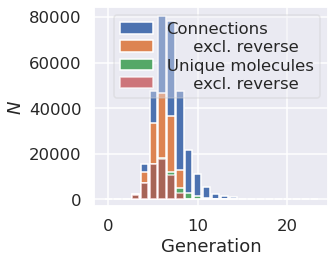

In [2]:
n_unique_compounds_generation = [1, 8, 170, 1762, 7260, 15668, 18131, 11849, 4979, 2764, 1499, 643, 372, 333, 113, 
                                 0, 0, 0, 0, 0, 0, 0, 0, 0]

n_unique_compounds_generation2 = [1, 8, 170, 1760, 7235, 15510, 17523, 10505, 2756, 303,
                                  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

n_connections_gen = [1, 8, 178, 2581, 15356, 47732, 80442, 78390, 47544, 21660,
                    11207, 5521, 2356, 1393, 874, 208, 0, 0, 0, 0, 0, 0, 0, 0]

n_connections_gen2 = [1, 8, 170, 2274, 12059, 33396, 46786, 36406, 12926, 
                      2032, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

plt.figure(figsize=(5,4))

plt.bar(list(range(len(n_unique_compounds_generation))),
        n_connections_gen, label='Connections')

plt.bar(list(range(len(n_unique_compounds_generation2))),
        n_connections_gen2, label='     excl. reverse')

plt.bar(list(range(len(n_unique_compounds_generation))),
        n_unique_compounds_generation, label='Unique molecules')

plt.bar(list(range(len(n_unique_compounds_generation2))),
        n_unique_compounds_generation2, label='     excl. reverse', alpha=0.75)

plt.legend(framealpha=0.4, labelspacing=0.2)
plt.ylim(-3000,)
plt.xlabel('Generation')
plt.ylabel('$N$')
plt.tight_layout()
plt.savefig('SI_figures/generation_network.pdf')
plt.show()

# Figure S3 b)

Optimized parameters: [ 0.16975139 -2.36274871]
R2-score: 0.9795694246308089


/data/kunkel/programs/miniconda_2/envs/orgel_py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/data/kunkel/programs/miniconda_2/envs/orgel_py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


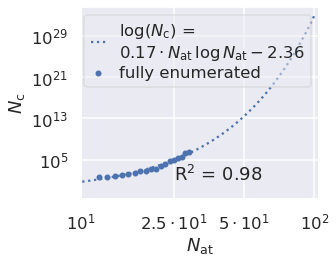

In [3]:
def func(x, a, b):
    return a*x*np.log(x)+b

# fit your data and getting fit parameters
xdata=np.array([12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
ydata=np.array([38,38,76,106,149,279,645,748,1322,1662,6127,11208,45870,83940,171687,364188,1503814,3014178])
popt, pcov = curve_fit(func, xdata, np.log(ydata), p0=[0.2, 0.2])

# predict new data based on your fit
y_pred = np.exp(func(100, *popt))

r2 = r2_score(np.log(ydata), func(xdata, *popt))
print("Optimized parameters: {}".format(popt))
print("R2-score: {}".format(r2))

fig, ax=plt.subplots(figsize=(5,4))
plt.scatter(xdata, ydata, label='fully enumerated',s=20)
plt.plot([x for x in range(101)], 
         np.exp(func(np.array([x for x in range(101)]), *popt)), '-', 
         label='$\mathrm{log}(N_\mathrm{c})$ = \n${%s\cdot}N_\mathrm{{at}}\,\mathrm{log}{\,N_\mathrm{{at}}%s}$'\
          %(round(float(popt[0]),2), round(float(popt[1]),2))
         , ls=':')

plt.xlabel('x')
plt.ylabel('y')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$N_\mathrm{at}$')
plt.ylabel('$N_\mathrm{c}$')
plt.xticks([10, 25, 50, 100], labels=['$10^1$', '$2.5\cdot10^1$', '$5\cdot10^1$', '$10^2$'])
plt.xlim(10,105)
plt.text(25,10,'$\mathrm{R^2}$ = '+str(round(r2,2)))
ax.legend(labelspacing=0.2, handlelength=0.9, fontsize=16.5, framealpha=0.5)
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('SI_figures/sizes_chemical_space_by_natom_extrapolated.pdf')

# Figure S5

In [4]:
# get number of rotatable bonds
pattern = Chem.MolFromSmarts("[#6R0]=[#6R0]")
df_chemical_space = pd.read_json('../data/df_chemical_space_chons_4rings.json',orient="split")
df_chemical_space['generation'] = [int(x) for x in df_chemical_space.generation.tolist()]
df_chemical_space.sort_values(by='generation',inplace=True)
df_chemical_space_unique = df_chemical_space.copy().drop_duplicates(subset='molecule_smiles')
df_chemical_space_unique['mols_rdkit'] = [Chem.MolFromSmiles(row.molecule_smiles) for i,row in df_chemical_space_unique.iterrows()]
df_chemical_space_unique['n_rot_bonds'] = [CalcNumRotatableBonds(row.mols_rdkit) for i,row in df_chemical_space_unique.iterrows()]
df_chemical_space_unique['n_double_bonds'] = [len(list(row.mols_rdkit.GetSubstructMatches(pattern))) for i,row in \
                                              df_chemical_space_unique.iterrows()]
df_chemical_space_unique['n_flex_bonds'] = df_chemical_space_unique['n_rot_bonds'] + df_chemical_space_unique['n_double_bonds']

print("Molecules with n double bonds: n=1: {} n2: {}"\
      .format(df_chemical_space_unique[df_chemical_space_unique.n_double_bonds==1].shape[0],\
             df_chemical_space_unique[df_chemical_space_unique.n_double_bonds==2].shape[0] ))

Molecules with n double bonds: n=1: 7318 n2: 9987


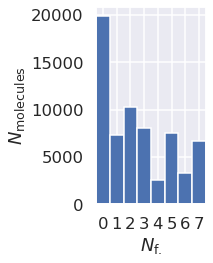

In [14]:
plt.figure(figsize=(3.3,4))
bins=list(range(9))
plt.hist(df_chemical_space_unique.n_flex_bonds, bins=bins)
plt.xlabel('$N_\mathrm{f.}$')
plt.ylabel('$N_\mathrm{molecules}$')

def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins[:-1], **kwargs)
    plt.xlim(bins[0], bins[-1])
bins_labels(bins)
plt.tight_layout()
plt.savefig('SI_figures/n_rot_bonds.svg')
plt.show()

In [15]:
# Conformer assessment:
# randomly selected from test space, contains 15 cases each for N_f from 0 to 7.
df_sel = pd.read_json('../data/df_conformers_random.json',orient="split")

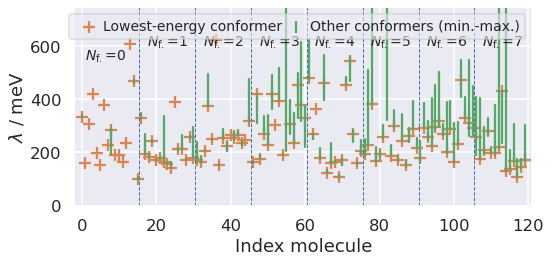

In [16]:
#lambda
plt.figure(figsize=(8,4))

o=-1
for i,row in df_sel.iterrows():
    o+=1
    e_lambdas_h_conformers = [linear_correct_to_b3lyp( 'XTB1_lamda_h', x ) for x in row.e_lambdas_h_conformers]
    plt.scatter(o, e_lambdas_h_conformers[np.argmin(row.e_total_conformers)],  c='C1', marker='+', s=130, zorder=2)
    plt.plot((o,o),( min(e_lambdas_h_conformers), max(e_lambdas_h_conformers)), c='C2')
    
plt.scatter(o, e_lambdas_h_conformers[np.argmin(row.e_total_conformers)],  c='C1', marker='+', s=130, zorder=2, label='Lowest-energy conformer')
plt.scatter(-10,-50, c='C2', marker='|', s=150, alpha=1., label='Other conformers (min.-max.)')
plt.ylabel('$\lambda$ / meV') 
plt.xlabel('Index molecule')
plt.xlim(-2,121)
plt.ylim(-3,750)
plt.vlines(15.5,0,750, lw=1., ls='--')
plt.vlines(30.5,0,750, lw=1., ls='--')
plt.vlines(45.5,0,750, lw=1., ls='--')
plt.vlines(60.5,0,750, lw=1., ls='--')
plt.vlines(75.5,0,750, lw=1., ls='--')
plt.vlines(90.5,0,750, lw=1., ls='--')
plt.vlines(105.5,0,750, lw=1., ls='--')
plt.text(1,550,'$N_\mathrm{f.}$=0', fontsize=14)
plt.text(2.5+15,600,'$N_\mathrm{f.}$=1', fontsize=14)
plt.text(17.5+15,600,'$N_\mathrm{f.}$=2', fontsize=14)
plt.text(32.5+15,600,'$N_\mathrm{f.}$=3', fontsize=14)
plt.text(47.5+15,600,'$N_\mathrm{f.}$=4', fontsize=14)
plt.text(62.5+15,600,'$N_\mathrm{f.}$=5', fontsize=14)
plt.text(77.5+15,600,'$N_\mathrm{f.}$=6', fontsize=14)
plt.text(92.5+15,600,'$N_\mathrm{f.}$=7', fontsize=14)
plt.legend(ncol=2, columnspacing=0.0, handletextpad=0.0, fontsize=14, framealpha=0.6, loc=1)
plt.tight_layout()
plt.savefig('SI_figures/conformers_lambda.svg')
plt.show()

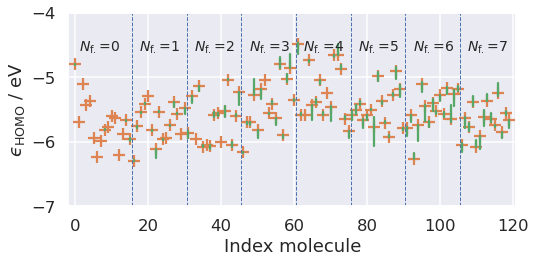

In [17]:
# Ehomo
plt.figure(figsize=(8,4))
o=-1
for i,row in df_sel.iterrows():
    o+=1
    e_homos_conformers = [linear_correct_to_b3lyp( 'ehomo_gfn1_b3lyp', x ) for x in row.e_homos_conformers]
    plt.scatter(o, e_homos_conformers[np.argmin(row.e_total_conformers)],  c='C1', marker='+', s=130, zorder=2)
    plt.plot((o,o),( min(e_homos_conformers), max(e_homos_conformers) ), c='C2')
    
plt.ylabel('$ϵ_\mathrm{HOMO}$ / eV') 
plt.xlabel('Index molecule')
plt.xlim(-2,121)
plt.ylim(-7,-4)
plt.vlines(15.5,-7,-4, lw=1., ls='--')
plt.vlines(30.5,-7,-4, lw=1., ls='--')
plt.vlines(45.5,-7,-4, lw=1., ls='--')
plt.vlines(60.5,-7,-4, lw=1., ls='--')
plt.vlines(75.5,-7,-4, lw=1., ls='--')
plt.vlines(90.5,-7,-4, lw=1., ls='--')
plt.vlines(105.5,-7,-4, lw=1., ls='--')
plt.text(1,-4.6,'$N_\mathrm{f.}$=0', fontsize=14)
plt.text(2.5+15,-4.6,'$N_\mathrm{f.}$=1', fontsize=14)
plt.text(17.5+15,-4.6,'$N_\mathrm{f.}$=2', fontsize=14)
plt.text(32.5+15,-4.6,'$N_\mathrm{f.}$=3', fontsize=14)
plt.text(47.5+15,-4.6,'$N_\mathrm{f.}$=4', fontsize=14)
plt.text(62.5+15,-4.6,'$N_\mathrm{f.}$=5', fontsize=14)
plt.text(77.5+15,-4.6,'$N_\mathrm{f.}$=6', fontsize=14)
plt.text(92.5+15,-4.6,'$N_\mathrm{f.}$=7', fontsize=14)
plt.tight_layout()
plt.savefig('SI_figures/conformers_e_homo.svg')
plt.show()